### General

In [1]:
from scipy.integrate import odeint
from scipy.stats import binned_statistic

import numpy as np
import sympy as sp
import networkx as nx
import os

import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
# Model equations
def f(x,y,alpha,beta,gamma):
    return -alpha*x + beta*y + gamma*(x**2)*y - gamma*x*(y**2)

def g(x,y,alpha,beta,gamma):
    return alpha*x - beta*y - gamma*(x**2)*y + gamma*x*(y**2)

def E_x(x, mu_x):
    return x*mu_x

def E_y(y, mu_y):
    return y*mu_y

def opinion_model(z, t, A, alpha, beta, gamma, mu_x, mu_y):
    omega = np.sum(A, axis=1)

    num_patches = len(z) // 2
    x_ = z[:num_patches]
    y_ = z[num_patches:]

    x = f(x_,y_,alpha, beta, gamma) - omega*E_x(x_, mu_x) + np.sum(A*E_x(x_,mu_x),axis=1)
    y = g(x_,y_,alpha, beta, gamma) - omega*E_y(y_, mu_y) + np.sum(A*E_y(y_,mu_y),axis=1)

    return np.concatenate([x,y])

In [3]:
def find_roots(a,b,c,d):
    """""a,b,c,d are the coefficients of the polynomial"""""

    x = sp.symbols('x')
    roots = sp.solve(a*x**3 + b*x**2 + c*x + d, x)
    real_roots = []
    for x in roots:
        if abs(sp.im(x).evalf()) < 10**(-15):
            x = sp.re(x)
        if x.is_real:
            x = float(x)
            real_roots.append(x)
    return real_roots

In [4]:
# Define the single patch Jacobian P
P_11 = lambda x,y,alpha,gamma: -gamma*y**2 + 2*gamma*x*y - alpha
P_12 = lambda x,y,beta,gamma: gamma*x**2 - 2*gamma*x*y + beta
P_21 = lambda x,y,alpha,gamma: gamma*y**2 - 2*gamma*x*y + alpha
P_22 = lambda x,y,beta,gamma: -gamma*x**2 + 2*gamma*x*y - beta

In [12]:
def draw_graph(G, exact_solution, frames, folder, sim, connectivity, norm_eigenvector):
    """"Draw the network at different time points with pie charts representing the proportions of the two opinions.
    G: networkx graph
    exact_solution: solution of the ODE system
    frames: list of time points to draw
    folder: folder to save the figures
    sim: simulation name
    connectivity: connectivity of the graph
    norm_eigenvector: eigenvector of the laplacian for coloring the nodes"""
    # find node near center (0.5,0.5)
    pos = nx.get_node_attributes(G, "pos")
    dmin = 1
    ncenter = 0
    for n_ in pos:
        x, y = pos[n_]
        d = (x - 0.5) ** 2 + (y - 0.5) ** 2
        if d < dmin:
            ncenter = n_
            dmin = d
    # path length from node near center
    p = dict(nx.single_source_shortest_path_length(G, ncenter))

    filenames = []
    patches = len(G.nodes)
    t_steps = len(exact_solution)

    for time_index in frames:
        # Calculate total abundance and proportions
        time = time_index/(t_steps//max_time)
        x_abundance = exact_solution[time_index,:patches]
        y_abundance = exact_solution[time_index,patches:]
        variable_1 = {i: x_abundance[i] for i in G.nodes()}
        variable_2 = {i: y_abundance[i] for i in G.nodes()}
        total_abundance = {i: variable_1[i] + variable_2[i] for i in G.nodes()}
        proportion_variable_1 = {i: variable_1[i] / total_abundance[i] for i in G.nodes()}
        proportion_variable_2 = {i: variable_2[i] / total_abundance[i] for i in G.nodes()}

        # Scale node sizes based on total abundance
        max_abundance = np.mean(list(total_abundance.values()))
        node_sizes = [(total_abundance[i] / max_abundance) for i in G.nodes()]  # Scaling for visibility
        # Opinion colors
        color_1 = mpl.colors.to_rgba('#5d81b4', 0.8) 
        color_2 = mpl.colors.to_rgba('#e09b24', 0.8)

        plt.figure(figsize=(8, 8))
        ax = plt.gca()
        nx.draw_networkx_edges(G, pos, alpha=0.8, ax=ax)
        # Draw nodes as pie charts
        for node in G.nodes():
            x, y = pos[node]
            size = node_sizes[node] / 75  # Adjust size for pie chart
            p1 = proportion_variable_1[node]
            p2 = proportion_variable_2[node]
            # Pie chart properties
            wedges, texts = ax.pie([p1, p2], colors=[color_1, color_2], radius=size, center=(x, y))
            for wedge in wedges:
                wedge.set_edgecolor('black')
            # if proportion of minority opinion larger than majority, add grey circle around
            if p1 > p2:
                circle = plt.Circle((x, y), size * 3, color="grey", fill=True, alpha=0.4)
                ax.add_artist(circle)
        plt.xlim(-0.05, 1.05)
        plt.ylim(-0.05, 1.05)
        plt.axis("off")
        # safe figure
        filename = f'{folder}{connectivity}/{sim}/time_{time}.pdf'
        if not os.path.exists(f'{folder}/{connectivity}/{sim}'):
            os.makedirs(f'{folder}/{connectivity}/{sim}')
        filenames.append(filename)
        plt.savefig(filename)
        plt.close()
    # draw the network colored by the eigenvector of the laplacian
    plt.figure(figsize=(8, 8))
    nx.draw(G, pos, node_color=norm_eigenvector, cmap=plt.cm.viridis,node_size=300, edge_color='gray')
    plt.savefig(f'{folder}/{connectivity}/{sim}/laplacian_ev.pdf')
    plt.close()

In [6]:
# Model parameters
alpha = 0.35
beta = 0.6
gamma = 0.025
M_val = 15
mu_x = 15
mu_y = 1
root_index = 0
# Integration parameters
t_steps = 1*10**5
max_time = 1000
t = np.linspace(0, max_time, t_steps)

In [7]:
folder = "random_graph_simulations/"
if not os.path.exists(folder):
    os.makedirs(folder)

patches = 50 # number of patches
connectivity = 0.2 # different connectivity values to use for the simulation
num_simulations = 10 # number of graphs to simulate
frames = [0,1,-1] # Time steps to be visualized

In [8]:
# Find the fixed points of the non-normalised 1 patch system for the homogenous state
# Coefficients of the polynomial
a_ = -2*gamma
b_ = (gamma*M_val+2*gamma*M_val)
c_ = (-alpha-beta-gamma*M_val**2)
d_ = beta*M_val

roots = find_roots(a_,b_,c_,d_)
root_x = roots[root_index]
root_y = M_val-root_x

root_x = roots[root_index]
root_y = M_val-root_x
noise = -0.5 + np.random.uniform(0, 1, size=patches)
x0 = np.full(patches, root_x) + noise
y0 = np.full(patches, root_y) - noise
z0 = np.concatenate([x0, y0])

# maximum kappa value for Turing instability
max_kappa = (P_11(root_x,root_y,alpha,gamma)/mu_x) + (P_22(root_x, root_y, beta, gamma)/mu_y)

In [9]:
 # Run simulations, collect data and visualize results
proportion_x_total = []
num_nodes_flipped = []
clustering = []
diameter = []
eigenvalues = []
norm_eigenvector_vals = []

for sim in range(0, num_simulations):
    # define initial condiitons
    noise = -0.5 + np.random.uniform(0, 1, size=patches)
    # Adjustments for presentation
    x0 = np.full(patches, 2) + noise
    y0 = np.full(patches, 13) + - noise
    indices = np.random.choice(len(x0), size=30, replace=False)
    x0[indices] = 0
    y0[indices] = 15
    z0 = np.concatenate([x0, y0])

    # find graph structure that is unstable and fully connected
    L_eigenvalues = np.array([10])
    while np.any(L_eigenvalues<max_kappa)==False:
        G = nx.random_geometric_graph(patches, connectivity)
        if nx.is_connected(G):
            A = nx.adjacency_matrix(G).toarray()
            L = nx.laplacian_matrix(G).toarray()
            L_eigenvalues, L_eigenvectors = np.linalg.eigh(L)

    # calculating exact solution
    exact_solution = odeint(opinion_model, z0, t, args=(A, alpha, beta, gamma, mu_x, mu_y))

    # extract solution
    x_abundance = exact_solution[:,:patches]
    y_abundance = exact_solution[:,patches:]
    total_x = np.sum(x_abundance[-1])
    total_y = np.sum(y_abundance[-1])
    num_nodes_flipped.append(len(np.where(x_abundance[-1]>y_abundance[-1])[0]))

    # extract graph measures
    laplacian = nx.laplacian_matrix(G).toarray()
    clustering.append(nx.average_clustering(G))
    diameter.append(nx.diameter(G))
    # second largest laplacian eigenvalue
    idx = np.argsort(L_eigenvalues)
    L_eigenvalues = L_eigenvalues[idx]
    L_eigenvectors = L_eigenvectors[:, idx]
    second_eigenvector = np.real(L_eigenvectors[:, 1])
    norm_eigenvector = (second_eigenvector - second_eigenvector.min()) / (second_eigenvector.max() - second_eigenvector.min())
    norm_eigenvector_vals.append(norm_eigenvector)
    # draw graph
    draw_graph(G, exact_solution, frames, folder, sim, connectivity, norm_eigenvector)

In [10]:
# Evaluate relationship between clustering and number of nodes flipped
num_bins = 15
bins = np.linspace(np.min(clustering), np.max(clustering), num_bins + 1)
# Compute mean and standard deviation of results for each bin
bin_means_c, bin_edges_c, _ = binned_statistic(clustering, num_nodes_flipped, statistic='mean', bins=bins)
bin_stds_c, _, _ = binned_statistic(clustering, num_nodes_flipped, statistic='std', bins=bins)
bin_centers_c = (bin_edges_c[:-1] + bin_edges_c[1:]) / 2

# Evaluate relationship between diameter and number of nodes flipped
num_bins = 15
bins = np.linspace(np.min(diameter), np.max(diameter), num_bins + 1)
# Compute mean and standard deviation of results for each bin
bin_means_d, bin_edges_d, _ = binned_statistic(diameter, num_nodes_flipped, statistic='mean', bins=bins)
bin_stds_d, _, _ = binned_statistic(diameter, num_nodes_flipped, statistic='std', bins=bins)
bin_centers_d = (bin_edges_d[:-1] + bin_edges_c[1:]) / 2

C:\Users\timauc002\AppData\Local\Temp\ipykernel_6272\1008905496.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


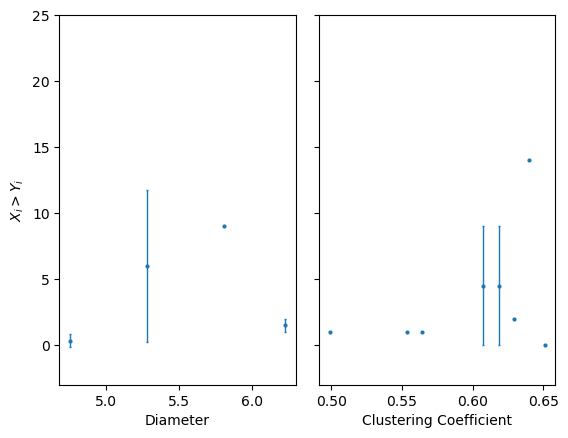

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, gridspec_kw={'wspace':0.1})

ax1.errorbar(bin_centers_d, bin_means_d, yerr=bin_stds_d, fmt='o', markersize=2, capsize=1,elinewidth=1)
ax1.set_xlabel("Diameter")
ax1.set_ylim([-3,25])
ax1.set_ylabel(r'$X_i>Y_i$')

ax2.errorbar(bin_centers_c, bin_means_c, yerr=bin_stds_c, fmt='o', markersize=2, capsize=1,elinewidth=1)
ax2.set_xlabel("Clustering Coefficient")
ax2.set_ylim([-3,25])
plt.tight_layout()
plt.show()